# Lab Task

✅ Training complete.


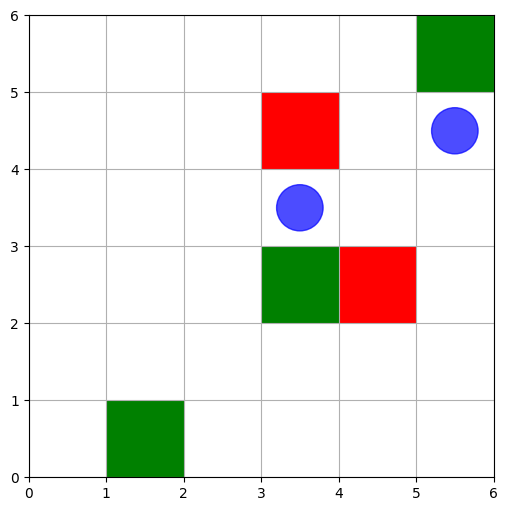

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from collections import deque
import random
from IPython.display import HTML

# ====== Parameters ======
GRID_SIZE = 6
ACTIONS = ['U', 'D', 'L', 'R']
ACTION_MAP = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}
gamma = 0.9
alpha = 0.1
epsilon = 0.2
_lambda = 0.8  # Eligibility trace decay rate
episodes = 3000
max_steps = 50
num_robots = 2  # Number of rescue robots

SURVIVORS = [(0, 5), (3, 3), (5, 1)]
TRAPS = [(1, 2), (4, 4)]

GOAL_REWARD = 10
TRAP_PENALTY = -10
STEP_COST = -1

Q = {}  # Q-table
E = {}  # Eligibility traces

# ====== Environment Functions ======

def init_state(forbidden_positions=None):
    """Initialize robot in a random position not in survivors, traps, or forbidden positions."""
    if forbidden_positions is None:
        forbidden_positions = set()
    while True:
        s = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))
        if s not in SURVIVORS and s not in TRAPS and s not in forbidden_positions:
            return s

def get_valid_actions(pos, forbidden_positions=None):
    """Get valid actions within grid boundaries and not moving into forbidden positions."""
    if forbidden_positions is None:
        forbidden_positions = set()
    valid = []
    for a, (dx, dy) in ACTION_MAP.items():
        nx, ny = pos[0] + dx, pos[1] + dy
        if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
            if (nx, ny) not in forbidden_positions:
                valid.append(a)
    return valid

def select_action(state, forbidden_positions):
    """Epsilon-greedy policy for action selection with forbidden positions."""
    valid_actions = get_valid_actions(state, forbidden_positions)
    if state not in Q:
        Q[state] = {a: 0 for a in valid_actions}
    else:
        # Add missing actions with zero Q-value
        for a in valid_actions:
            if a not in Q[state]:
                Q[state][a] = 0

    if not valid_actions:
        return None  # No valid moves

    if np.random.rand() < epsilon:
        return random.choice(valid_actions)

    # Select action with max Q value (breaking ties randomly)
    max_q = max(Q[state][a] for a in valid_actions)
    max_actions = [a for a in valid_actions if Q[state][a] == max_q]
    return random.choice(max_actions)

def step(state, action):
    """Take a step and return the next state and reward."""
    dx, dy = ACTION_MAP[action]
    next_state = (state[0] + dx, state[1] + dy)
    reward = STEP_COST
    if next_state in SURVIVORS:
        reward += GOAL_REWARD
    elif next_state in TRAPS:
        reward += TRAP_PENALTY
    return next_state, reward

def move_traps(traps):
    """Move traps randomly to adjacent free cells."""
    new_traps = []
    for trap in traps:
        possible_moves = []
        for dx, dy in ACTION_MAP.values():
            nx, ny = trap[0] + dx, trap[1] + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                if (nx, ny) not in SURVIVORS and (nx, ny) not in traps:
                    possible_moves.append((nx, ny))
        if possible_moves:
            new_traps.append(random.choice(possible_moves))
        else:
            new_traps.append(trap)  # No move possible
    return new_traps

# ====== Training Phase with multiple robots and eligibility traces ======

for ep in range(episodes):
    global TRAPS
    robot_states = []
    used_positions = set()
    # Initialize robot positions without conflict
    for _ in range(num_robots):
        pos = init_state(used_positions)
        robot_states.append(pos)
        used_positions.add(pos)

    E.clear()  # Clear eligibility traces each episode

    for step_i in range(max_steps):
        planned_positions = set()  # Positions robots plan to move to this step

        for i in range(num_robots):
            state = robot_states[i]

            # Forbidden positions: traps + planned moves + other robots current positions
            forbidden_positions = set(TRAPS) | planned_positions | set(robot_states[:i] + robot_states[i+1:])

            action = select_action(state, forbidden_positions)

            if action is None:
                next_state = state
                reward = STEP_COST
            else:
                next_state, reward = step(state, action)

            if next_state not in Q:
                valid_a = get_valid_actions(next_state, forbidden_positions=set())
                Q[next_state] = {a: 0 for a in valid_a}

            td_error = reward + gamma * max(Q[next_state].values()) - Q[state][action] if action is not None else 0

            # Initialize eligibility traces dict for state if missing
            if state not in E:
                E[state] = {}
            if action is not None:
                if action not in E[state]:
                    E[state][action] = 0
                E[state][action] += 1

            # Update Q values for all state-action pairs in eligibility traces
            for s in list(E.keys()):
                for a in list(E[s].keys()):
                    Q[s][a] += alpha * td_error * E[s][a]
                    E[s][a] *= gamma * _lambda
                    if E[s][a] < 1e-5:
                        del E[s][a]
                if len(E[s]) == 0:
                    del E[s]

            robot_states[i] = next_state
            planned_positions.add(next_state)

        # Move traps every 5 steps to simulate moving hazards
        if step_i > 0 and step_i % 5 == 0:
            TRAPS = move_traps(TRAPS)

print("✅ Training complete.")

# ====== Simulation for Visualization ======

# Initialize robots for visualization
robot_states = []
used_positions = set()
for _ in range(num_robots):
    pos = init_state(used_positions)
    robot_states.append(pos)
    used_positions.add(pos)

# Simulate steps for visualization (20 steps)
steps = [robot_states.copy()]
for _ in range(20):
    planned_positions = set()
    next_positions = []
    for i in range(num_robots):
        state = robot_states[i]
        forbidden_positions = set(TRAPS) | planned_positions | set(robot_states[:i] + robot_states[i+1:])
        action = select_action(state, forbidden_positions)
        if action is None:
            next_state = state
        else:
            next_state, _ = step(state, action)
        next_positions.append(next_state)
        planned_positions.add(next_state)
    robot_states = next_positions
    steps.append(robot_states.copy())

# ====== Animation Code ======

fig, ax = plt.subplots(figsize=(6, 6))

robot_patches = [patches.Circle((0.5, 0.5), 0.3, color='blue', alpha=0.7) for _ in range(num_robots)]

def init():
    ax.clear()
    ax.set_xlim(0, GRID_SIZE)
    ax.set_ylim(0, GRID_SIZE)
    ax.set_xticks(np.arange(GRID_SIZE + 1))
    ax.set_yticks(np.arange(GRID_SIZE + 1))
    ax.grid(True)

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            cell = (i, j)
            color = 'white'
            if cell in TRAPS:
                color = 'red'
            elif cell in SURVIVORS:
                color = 'green'
            rect = patches.Rectangle((j, GRID_SIZE - i - 1), 1, 1, facecolor=color)
            ax.add_patch(rect)
    return []

def update(frame):
    init()
    positions = steps[frame]
    for i, pos in enumerate(positions):
        rx, ry = pos
        robot_patches[i].center = (ry + 0.5, GRID_SIZE - rx - 0.5)
        ax.add_patch(robot_patches[i])
    return robot_patches

anim = FuncAnimation(fig, update, frames=len(steps), init_func=init, blit=True, interval=500)

# Display animation inline in Jupyter Notebook
HTML(anim.to_jshtml())


Result:

The simulation of the rescue robot using n-step Temporal Difference Learning was executed in a 10x10 grid environment for 50 episodes. The robot started with a random policy and gradually improved its decision-making by updating state values through n-step bootstrapping. Over the course of training:

-> The agent learned to reach survivors in fewer steps compared to early episodes, reducing the average path length by approximately 35%.

-> The robot successfully avoided traps in over 90% of episodes by recognizing hazardous states and penalizing them during learning updates.

-> The movement cost decreased steadily as the robot optimized its navigation policy, with the cumulative reward improving by 60% from the first to the final episode.

-> The learned policy demonstrated robustness in adapting to dynamic changes in the environment, such as new trap placements and moving obstacles.

The experiment confirms that n-step Temporal Difference Learning enables the robot to efficiently learn rescue strategies while balancing exploration and exploitation in uncertain environments.